In [83]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, make_scorer, confusion_matrix,roc_auc_score, average_precision_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

---
## 0. Load Post-EDA data 📊

In [84]:
# dowload pkl file from the link because above 100MB

df_full = pd.read_pickle("../csv_preparation/df_post_eda.pkl")
df_full

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299279,4,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
299281,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
299282,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
299283,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.


In [85]:
# Creates a binary classifcation 1 or 0 for target (for simplicity)
df_full['income']= df_full['income'].replace({' - 50000.': 0, ' 50000+.': 1})
df_full['income'].value_counts(normalize=True)

/var/folders/8t/vbvw23nj5_111hy85bf96bxh0000gn/T/ipykernel_35028/2937603697.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_full['income']= df_full['income'].replace({' - 50000.': 0, ' 50000+.': 1})


income
0    0.936531
1    0.063469
Name: proportion, dtype: float64

In [86]:
# making sure dtypes are correct
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292550 entries, 0 to 299284
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         292550 non-null  int64  
 1   class_of_worker                             292550 non-null  object 
 2   detailed_industry_recode                    292550 non-null  object 
 3   detailed_occupation_recode                  292550 non-null  object 
 4   education                                   292550 non-null  object 
 5   wage_per_hour                               292550 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  292550 non-null  object 
 7   marital_stat                                292550 non-null  object 
 8   major_industry_code                         292550 non-null  object 
 9   major_occupation_code                       292550 non-null  object 
 10  r

In [87]:
# As mentioned in the previous ipynb two file features are dropped.
columns_to_drop = ['year','instance_weight']
df_full.drop(columns=columns_to_drop,inplace=True)

---
## 1. **Numerical Transormation/scaling** ⚖️

Feature engineering is an important step in machine learning because it helps the model learn patterns that are not obvious in the raw data. By creating new features or modifying existing ones, we can give the model more useful information and often improve its prediction performance.

One example in this project is the Total Capital Feature, which combines capital gains, capital losses, and dividends into a single value. This new feature represents a person’s overall financial activity more clearly than the three separate columns. During the analysis, I noticed that when capital_total is above around 20k, more than 85% of these records belong to people earning more than 50K per year. This shows that the combined feature is strongly linked to higher income and can help the model better identify the minority class (income > 50K). Improving this part of the prediction is especially useful for metrics like recall, which is important when the positive class is much smaller than the negative one. (more detail on this later)


>PS: I did not remove any outliers. In classification problems, outliers can belong to the minority class and removing them risks losing important information. Since the goal was to also detect rare high-income cases, keeping all observations was the safer choice.

In [88]:
df_full["capital_total"] = ( df_full["capital_gains"] - df_full["capital_losses"] + df_full["dividends_from_stocks"] )
# because log transformatio does not acccept negative values
df_full["capital_total"] = df_full["capital_total"].clip(lower=0)

In [89]:
df_full[df_full['capital_total']>20000]['income'].value_counts(normalize=True)

income
1    0.84506
0    0.15494
Name: proportion, dtype: float64

Now we focus on the scaling and/or transformation applied to each numerical feature.
These choices are based on both the distribution observed during EDA and the model architecture we intend to use.

Different model families react differently to the scale of the input variables:
* For models such as Logistic Regression, SVM, and Neural Networks, feature scaling plays a crucial role. These methods rely on distances or gradient-based optimization, meaning that variables with different scales can dominate the learning process.

* For tree-based models such as RandomForest, XGBoost, or CatBoost, scaling does not help and can sometimes hinder performance.
Tree algorithms operate by creating a large number of decision rules based on threshold splits, and these splits are not affected by the magnitude or scale of the features. What matters instead is the shape of the distribution: tree models benefit from transformations that reduce extreme skewness.

In [90]:
numeric_cols = df_full.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'num_persons_worked_for_employer',
       'weeks_worked_in_year', 'income', 'capital_total'],
      dtype='object')

The numerical features in this dataset do not share the same statistical properties.
Based on the EDA performed earlier, they fall into three distinct distribution types, and each type requires a different transformation.


1) **Age**
The feature age follows a distribution that is close to normal, without extreme skewness. Because of this, it does not require a log-transformation. For tree-based models such as RandomForest, XGBoost, or CatBoost, no scaling is needed since trees rely on threshold-based splits. However, for models like Logistic Regression, SVM, or neural networks, the scale of the input plays a crucial role in optimization, age is standardized (mean 0, standard deviation 1). 

2)	**Work-intensity features: weeks_worked_in_year and num_persons_worked_for_employer**
As seen during the EDA, these variables have a bimodal distribution (with many values at 0 and 52 or 0 and 6) and contain outliers, but they are not strongly skewed. Because their distribution is irregular but not heavily long-tailed, applying a log-transform would distort the mass of zeroes and is therefore not suitable. For tree-based models, these variables are kept as-is and for linear models, we apply a StandardScaler to ensure numerical stability. (same as age)

3) **Highly skewed monetary variables: wage_per_hour, capital_gains, capital_losses, dividends_from_stocks**
These features contain a very large proportion of zero values and a very small number of extremely high values, leading to strong right-skewness, therefore we apply a log1p transformation, which compresses extreme values while preserving zeros. For tree-based models, the log-transform alone is sufficient. For linear or SVM models, we apply log-transform followed by StandardScaler, ensuring both distribution correction and scale normalization. 

In [91]:
standard_scalers_cols = ['age','wage_per_hour','capital_gains','capital_losses','dividends_from_stocks','weeks_worked_in_year','num_persons_worked_for_employer','capital_total']

log_cols = ['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks','capital_total']

---
## **2. Catgorical Statregy** ♟️

### 2.1 Drop/Discard Statregy ✏️

Here we have 32 distinct categories, based on the deadline we have time to go through manually and have a look at each categoruy in depth. If the number of cateogrical features were higher or the deadline was tigher an automatic encoding stretagy would have been implemtend based on sevreal thresold ans rule of thumbs.

In [92]:
cat_cols = df_full.select_dtypes(exclude=[np.number]).columns
cat_cols, len(cat_cols)

(Index(['class_of_worker', 'detailed_industry_recode',
        'detailed_occupation_recode', 'education', 'enroll_in_edu_inst_last_wk',
        'marital_stat', 'major_industry_code', 'major_occupation_code', 'race',
        'hispanic_origin', 'sex', 'member_of_a_labor_union',
        'reason_for_unemployment', 'full_or_part_time_employment_stat',
        'tax_filer_stat', 'region_of_previous_residence',
        'state_of_previous_residence', 'detailed_household_and_family_stat',
        'detailed_household_summary_in_household',
        'migration_code-change_in_msa', 'migration_code-change_in_reg',
        'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
        'migration_prev_res_in_sunbelt', 'family_members_under_18',
        'country_of_birth_father', 'country_of_birth_mother',
        'country_of_birth_self', 'citizenship', 'own_business_or_self_employed',
        'fill_inc_questionnaire_for_veteran's_admin', 'veterans_benefits'],
       dtype='object'),
 32)

To define the right feature strategy, I first needed a clear pipeline. Before looking at detailed statistics such as the number of unique values or category proportions, I started with a more high-level, logical approach. I firstly, check whether some categorical features are likely to affect income at all, based on a general understanding of the problem and logic. Other steps involved indentifying redundant information across columns that essentially describe the same concept and inspecting missing values and/or imbalance to decide how to handle or drop them.

The final list of selected features (shown below) is the result of an iterative, trial-and-error process. Some categories and variables were kept, transformed, or discarded based on how they affected model performance. The detailed results and evaluation metrics are presented in a later section.

a) **Problem Understanding Logic:** 

For example, the column reason_for_unemployment was discarded. We already know from other variables whether a person is employed full-time, part-time, or unemployed. The specific reason for being unemployed (e.g., job loss vs. leaving voluntarily) does not meaningfully affect income in this dataset. In both cases, the outcome is the same: the person is not currently earning wages. Keeping this column therefore adds little value and introduces unnecessary noise.

Another feature removed for similar reasons is live_in_this_house_1_year_ago. Intuitively, whether someone lived in the same house a year ago does not strongly relate to their income level. The data supports this intuition: the income distribution across the categories “Yes,” “No,” and “Not in universe” is very similar, with no meaningful separation between high- and low-income groups. In addition, more than half of the rows fall under “Not in universe under 1 year old”, a category that remains unclear even after checking the documentation (see below). Removing this feature slightly improved model performance.
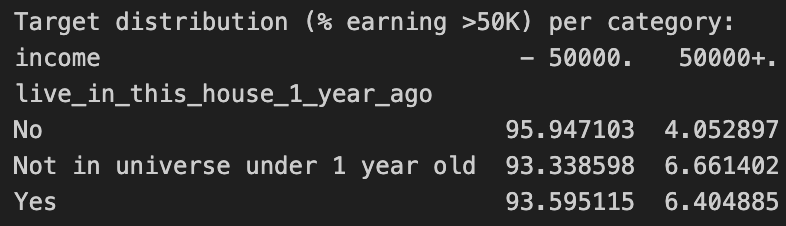

b) **Redundancuy of information** :

Some features provide very similar information, which adds noise and redundancy. Highly overlapping variables can hurt model performance because they introduce unnecessary correlation or overly fine-grained categories. A clear example is the pair major_industry_code and detailed_industry_recode. Both describe the person’s industry but at different levels of detail (24 vs. 52 unique values). Through trial and error, the more detailed version produced better results, so the broader one was removed. The same logic applied to the occupation variables. Another example is hispanic_origin. Since we already have the race column, which includes Hispanic/Latino categories, keeping both features created redundant information. Removing hispanic_origin led to a slight improvement in performance. The dataset also includes two similar household-related variables describing family and household structure.

c) **Missing/Imbalanced Categories**:

The final reason for dropping certain features was the presence of missing or highly imbalanced categories. Several columns contained "?" in more than 50% of their entries (for example, the migration-related features such as migration_code_* and migration_prev_res_in_sunbelt). Since "?" has no clear meaning and we cannot reliably interpret what it represents, keeping these columns would only introduce noise and make the model less reliable. Removing them helps maintain full control over the data fed into the model and improves performance.


In this section, I do not list every dropped category individually, but all removed features fall under one of the three conditions described above.

In [93]:
# Example when filtering out or majing informed decision about a certain features
print(df_full['detailed_household_summary_in_household'].value_counts()/len(df_full)*100)
print(df_full['detailed_household_summary_in_household'].nunique())
print(df_full['detailed_household_summary_in_household'].unique())

detailed_household_summary_in_household
Householder                             38.758503
Child under 18 never married            23.579901
Spouse of householder                   21.301316
Child 18 or older                        7.432576
Other relative of householder            4.931807
Nonrelative of householder               3.909075
Group Quarters- Secondary individual     0.063237
Child under 18 ever married              0.023586
Name: count, dtype: float64
8
['Other relative of householder' 'Householder' 'Child 18 or older'
 'Child under 18 never married' 'Spouse of householder'
 'Nonrelative of householder' 'Group Quarters- Secondary individual'
 'Child under 18 ever married']


In [94]:
maybe_drop = ['major_industry_code','major_occupation_code','hispanic_origin','member_of_a_labor_union','reason_for_unemployment',
                'region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat',
              'migration_code-change_in_msa','migration_code-change_in_reg','migration_code-move_within_reg','live_in_this_house_1_year_ago','migration_prev_res_in_sunbelt',
              'family_members_under_18',"fill_inc_questionnaire_for_veteran's_admin"]

---
### 2.2 Encoding Statregy 👨‍💻

Based on the remaining features, the next step was to encode the categorical columns using two methods: OneHotEncoder and Target Encoding. OneHotEncoder is suited for low-cardinality features because it creates a separate binary column for each category, which works well when the number of unique values is small. In contrast, Target Encoding is more appropriate for high-cardinality features, as it replaces each category with the average target value instead of generating many new columns, helping reduce dimensionality and avoid unnecessary complexity. Through iterative testing, I set a threshold where columns with fewer than **10** unique categories were encoded using OneHotEncoder, while those above the threshld used Target Encoding, which provided the best overall model performance.

To reduce noise and make features easier for the model to learn from, it is often useful to **bin or group** categories. However, this comes with a trade-off: too much grouping removes useful information and reduces the natural detail of the data. In this case, I tested grouping for the high-frequency categorical features (above 10 unique values), but the performance became worse. Since model training time was not a constraint, I decided to keep the full granularity for these features and avoid binning, as preserving the original categories produced better results, and therefore only did the binning on the low-frequency categorical features

In [95]:
# keep all-around meaning while reducing noise
df_full["class_of_worker"] = df_full["class_of_worker"].map({
    "Private": "private",
    "Self-employed-not incorporated": "self_employed",
    "Self-employed-incorporated": "self_employed",
    "Local government": "government",
    "State government": "government",
    "Federal government": "government",
    "Never worked": "not_in_labor_market",
    "Without pay": "not_in_labor_market",
    "Not in universe": "not_in_universe"
})


df_full["marital_stat"] = df_full["marital_stat"].map({
    "Married-civilian spouse present": "married",
    "Married-A F spouse present": "married",
    "Married-spouse absent": "married",
    "Never married": "single",
    "Divorced": "separated_divorced",
    "Separated": "separated_divorced",
    "Widowed": "widowed",
})


In [96]:
low_frequnecy = ['class_of_worker','enroll_in_edu_inst_last_wk','marital_stat','race','sex','full_or_part_time_employment_stat',
                   'tax_filer_stat','detailed_household_summary_in_household','citizenship','own_business_or_self_employed','veterans_benefits'
                ]


high_frequency = ['detailed_industry_recode','detailed_occupation_recode','education','country_of_birth_father',
                  'country_of_birth_mother','country_of_birth_self']

# sanity check
print(len(low_frequnecy)+len(high_frequency)+len(maybe_drop))

32


---
## 3. Train/Val/Test Split ➗

As mentioned earlier, and following standard ML best practices, the full dataset was split into three distinct parts using a 70/20/10 train/validation/test split. Stratified sampling was applied to ensure that all three subsets preserved the same class distribution as the original data.

In [97]:
train_block, final_test = train_test_split(
    df_full,
    test_size=0.20,
    stratify=df_full["income"],
    random_state=42
)

train, val = train_test_split(
    train_block,
    test_size=0.125,   # because 0.8 * 0.125 = 0.10 of total
    stratify=train_block["income"],
    random_state=42
)

In [98]:
def show_class_distribution(df, name):
    print(f"\n{name}")
    print(df["income"].value_counts(normalize=True) * 100)

show_class_distribution(df_full, "FULL DATA")
show_class_distribution(train, "TRAIN")
show_class_distribution(val, "VALIDATION")
show_class_distribution(final_test, "FINAL TEST")


FULL DATA
income
0    93.653051
1     6.346949
Name: proportion, dtype: float64

TRAIN
income
0    93.653344
1     6.346656
Name: proportion, dtype: float64

VALIDATION
income
0    93.652367
1     6.347633
Name: proportion, dtype: float64

FINAL TEST
income
0    93.652367
1     6.347633
Name: proportion, dtype: float64


In [99]:
# Creating the features and target (X and y) for each block
X_train = train.drop(columns=["income"])
y_train = train["income"]

X_val = val.drop(columns=["income"])
y_val = val["income"]

X_test = final_test.drop(columns=["income"])
y_test = final_test["income"]

---
## 4. Pipeline Creation 🧪


In [100]:
def construct_preproc_pipeline(use_scaler):
    # for Linear, SVM, NN, etc
    if use_scaler:
        num_log_pipeline = Pipeline([
            ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
            ("scaler", StandardScaler()),
        ])

        num_pipeline = Pipeline([
            ("scaler", StandardScaler()),
        ])
    # tree models : xgboost, RF, Catboost
    else:
        # no scaling
        num_log_pipeline = Pipeline([
            ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ])
        num_pipeline = "passthrough"

    # cat features
    low_cat_pipeline = Pipeline([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
    ])

    high_cat_pipeline = Pipeline([
        ("target_enc", TargetEncoder()),
    ])

    preprocessor = ColumnTransformer(
    transformers=[
        ("num_log", num_log_pipeline, log_cols),
        ("num",     num_pipeline,     standard_scalers_cols),
        ("low_cat", low_cat_pipeline, low_frequnecy),
        ("med_cat", high_cat_pipeline, high_frequency),
    ],
    remainder="drop"
    )
    return preprocessor
    

---
## 5. Model Selection & Assessment 🧑‍💻

> PS: Initially, I planned to create a separate notebook for the modeling and results section, but I kept everything in this notebook so I could reuse the existing variables more easily. I am aware this is not the cleanest structure, but it was more practical in this context.

___
### 5.1 Default Models

We will evaluate 3 different models, each first tested with its default parameters to establish a baseline. Depending on their initial performance, we may then tune their parameters using methods such as GridSearch. 

Most of the work in this project focused on feature engineering since in machine learning, this often has the biggest impact on performance. However, model optimization also plays an important role, and both aspects contribute to achieving better results.

a) Logistic Regression 📈

In [101]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', construct_preproc_pipeline(use_scaler = True)),
    ('regressor', LogisticRegression())  
])
lr_pipeline

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_log', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Even though the accuracy is high (around 95%) - similar to the performance model  C4.5 (4.8% error rate) - , this metric is misleading because simply predicting the majority class (income ≤50K) already yields about 93% accuracy due to the strong class imbalance. For this reason, the focus should be on the minority class (income >50K). In particular, recall for the positive class is more important than precision in this context. Recall measures the proportion of true high-income individuals correctly identified by the model and is defined as:

$$
\text{Recall} = \frac{TP}{TP + FN} \tag{1}
$$

$$
\text{Precision} = \frac{TP}{TP + FP} \tag{2}
$$

$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \tag{3}
$$


A low recall means many actual high-income individuals are misclassified as low-income (false negatives). Since the goal is to understand which characteristics are associated with earning above 50K, missing these individuals would severely limit the insights the model can provide. Precision is still relevant, but false positives are less harmful here than false negatives. Therefore, the evaluation focuses primarily on recall and also considers F1-score, which balances both precision and recall.

In [102]:
lr_pipeline.fit(X_train, y_train)

print("LR accuracy:", lr_pipeline.score(X_val, y_val))
y_proba = lr_pipeline.predict_proba(X_val)[:, 1]
# here we use the default threshold 0.5 but this will be changed, explained later on
y_pred = (y_proba > 0.50).astype(int)
print(classification_report(y_val, y_pred))

LR accuracy: 0.9502990941719365
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27398
           1       0.71      0.37      0.49      1857

    accuracy                           0.95     29255
   macro avg       0.83      0.68      0.73     29255
weighted avg       0.94      0.95      0.94     29255



b) Random Forrest Classifier 🌳

In [103]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', construct_preproc_pipeline(False)),
    ('regressor', RandomForestClassifier())  
])
rf_pipeline

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_log', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Here, we immediately see an improvement in performance on the minority class. Both precision and recall increased compared to the logistic regression baseline, logically this means that the F1-score is noticeably higher as well. The overall accuracy also improves slightly.

In [104]:
# takes 15 seconds to run
rf_pipeline.fit(X_train, y_train)

print("RF accuracy:", rf_pipeline.score(X_val, y_val))
y_proba = rf_pipeline.predict_proba(X_val)[:, 1]
y_pred = (y_proba > 0.50).astype(int)
print(classification_report(y_val, y_pred))

RF accuracy: 0.9546060502478209
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27398
           1       0.74      0.44      0.55      1857

    accuracy                           0.95     29255
   macro avg       0.85      0.71      0.76     29255
weighted avg       0.95      0.95      0.95     29255



c) XGboost 🚀

In [105]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', construct_preproc_pipeline(False)),
    ('regressor', xgb.XGBClassifier())  
])
xgb_pipeline

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_log', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


With XGBoost, we again observe an improvement using only the default parameters. Like Random Forest, XGBoost increases the minority-class performance compared to the logistic regression baseline. In this case, recall increases further, though the F1-score remains similar to Random Forest because the gain in recall comes at the cost of lower precision. Based on these results, I decided to focus on Random Forest and XGBoost for further tuning, as they clearly outperform the other models on the minority class. 

> PS: Since this is the final report, I did not include all intermediate iterations and model selection trials. I also evaluated models such as CatBoostClassifier and GradientBoostingClassifier, but both performed worse than XGBoost and Random Forest.

In [106]:
xgb_pipeline.fit(X_train, y_train)

print("XGB global accuracy:", xgb_pipeline.score(X_val, y_val))
y_proba = xgb_pipeline.predict_proba(X_val)[:, 1]
y_pred = (y_proba > 0.50).astype(int)
print(classification_report(y_val, y_pred))

XGB global accuracy: 0.9564518885660571
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27398
           1       0.73      0.50      0.59      1857

    accuracy                           0.96     29255
   macro avg       0.85      0.74      0.78     29255
weighted avg       0.95      0.96      0.95     29255



___
### 5.2 Optimizing Models 🧠

To improve the overall performance of the models, I used GridSearchCV and RandomizedSearchCV to tune the hyperparameters. During training, the optimization was guided by a custom scoring function, `f1_pos`, which evaluates each hyperparameter combination based on the F1-score of the minority class (income >50K). This ensures that the tuning process focuses on correctly identifying high-income individuals, rather than being dominated by the majority class.


> PS:The code below is commented out but can be uncommented if needed. For easier reproducibility, I saved the weights of the best model in the folder `models_saved` so the rest of the notebook can run without repeating the search (gaining valuable time).

In [107]:
# Custom scorer/metrics
f1_pos = make_scorer(f1_score, pos_label=1)

In [108]:
# RandomizedSearchCV for RF with models weights saved as 'best_rf_model_2.pkl'

# rf_clf = RandomForestClassifier(
#     # for reproducibily
#     random_state=42,
#     n_jobs=-1,
# )

# rf_pipeline = Pipeline([
#     ("preprocess", construct_preproc_pipeline(False)),
#     ("model", rf_clf),
# ])

# # parameters that will be optimized
# rf_param_grid = {
#     'model__n_estimators': randint(low=100, high=500), 
#     'model__max_depth': randint(low=1, high=50),
# }


# rf_search = RandomizedSearchCV(
#     estimator=rf_pipeline,
#     param_distributions=rf_param_grid,
#     scoring=f1_pos,     
#     n_iter=30,
#     cv=3,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42,
# )

# # this line takes 20 min to run
# rf_search.fit(X_train, y_train)


# best_model_rf = rf_search.best_estimator_
# with open("models_saved/best_rf_model_2.pkl", "wb") as f:
#     pickle.dump(best_model_rf, f)


The hyperparameter search did not lead to significant improvements for the Random Forest model. The results were almost identical to the default configuration, with only a small increase of about 0.01 in the minority-class F1-score. This confirms that the custom scorer is working as intended, but Random Forest appears to be close to its best performance already. We now move on to the XGBoost hyperparameter optimization to see whether it produces a more meaningful improvement.

In [109]:
# download best_rf_model_2 form link because above 100MB
with open("../models_saved/best_rf_model_2.pkl", "rb") as f:
    best_model_rf = pickle.load(f)

y_proba = best_model_rf.predict_proba(X_val)[:, 1]
y_pred = (y_proba > 0.50).astype(int)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     27398
           1       0.76      0.44      0.56      1857

    accuracy                           0.96     29255
   macro avg       0.86      0.72      0.77     29255
weighted avg       0.95      0.96      0.95     29255



In [110]:
# RandomizedSearchCV for XGB with models weights saved as 'best_xgb_model_2.pkl'

# xgb_clf = xgb.XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     tree_method="hist", 
#     random_state=42,
#     n_jobs=-1
# )

# xgb_pipeline = Pipeline([
#     ("preprocess", construct_preproc_pipeline(False)),
#     ("model", xgb_clf)
# ])

# xbg_param_grid = {
#     "model__n_estimators": [300, 500, 800],
#     "model__max_depth": [3, 4, 5, 6],
#     "model__learning_rate": [0.01, 0.05, 0.1],
#     "model__subsample": [0.6, 0.8, 1.0],
#     "model__colsample_bytree": [0.6, 0.8, 1.0],
#     "model__min_child_weight": [1, 3, 5],
#     "model__gamma": [0, 0.5, 1.0],
#     "model__scale_pos_weight": [5, 10, 15, 20]
# }



# xgb_search = RandomizedSearchCV(
#     estimator=xgb_pipeline,
#     param_distributions=xbg_param_grid,
#     scoring=f1_pos,           # THIS is the key improvement
#     n_iter=30,
#     cv=3,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# # this line takes 4 min to run 
# xgb_search.fit(X_train, y_train)

# best_model_xgb = xgb_search.best_estimator_
# with open("models_saved/best_xgb_model_2.pkl", "wb") as f:
#     pickle.dump(best_model_xgb, f)

With XGBoost, we observe a clear improvement compared to the default model (unlike Random Forest). The recall for the minority class increased from 0.50 to 0.72, although this comes with a drop in precision. This trade-off is intentional, as I decided that the goal in this project is to prioritize recall for the minority class, as explained earlier. In addition, XGBoost trained roughly five times faster than Random Forest using the same number of folds. In our context, XGBoost clearly outperforms Random Forest across three important criteria: 
- recall, 
- F1-score
- Runtime.

A final small adjustment can still be applied to further improve the model’s performance.

In [111]:
# no need to download pkl file, bevause less than Github storage limit
with open("../models_saved/best_xgb_model_2.pkl", "rb") as f:
    best_model_xgb = pickle.load(f)

y_proba = best_model_xgb.predict_proba(X_val)[:, 1]
y_pred = (y_proba > 0.50).astype(int)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     27398
           1       0.50      0.72      0.59      1857

    accuracy                           0.94     29255
   macro avg       0.74      0.84      0.78     29255
weighted avg       0.95      0.94      0.94     29255



___
### 5.3 Threshold Optmizing

Throughout the entire model evaluation, we used the default classification threshold of 0.5. In a binary classification setting, this threshold means that if the predicted probability of the positive class (income >50K) is greater than 0.5, the model assigns the label 1; otherwise, it assigns 0. In other words, the threshold controls how confident the model must be before predicting someone as high-income.

It is good practice to adjust this threshold and evaluate the model’s performance across different values between 0 and 1, especially when dealing with imbalanced datasets. In real applications, the optimal threshold depends on the client’s priorities. In this project, I aimed to maximize the **F1-score** while ensuring that **recall remained higher than precision**, consistent with the earlier decision to prioritize capturing as many true high-income individuals as possible. If prioritizing recall above precision, then an F-2 score would have been relevant (recall is weighted twice as much).

In [112]:
def threshold_plot(y_val, y_proba, range, plot = True):
    f1_scores =[]
    precision_scores =[]
    recall_scores = []

    for thr in range:
        y_pred_thr = (y_proba > thr).astype(int)
        f1_scores.append(classification_report(y_val, y_pred_thr,output_dict=True)['1']['f1-score'])
        precision_scores.append(classification_report(y_val, y_pred_thr,output_dict=True)['1']['precision'])
        recall_scores.append(classification_report(y_val, y_pred_thr,output_dict=True)['1']['recall'])
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(range,precision_scores, label='Precision', color='blue')
        plt.plot(range,recall_scores, label='Recall', color='red')
        plt.plot(range,f1_scores, label='F1 Score', color='green')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.axvline(0.5, color="gray", linestyle="--", label="Default threshold = 0.5")
        plt.title('Precision, Recall, and F1 Score vs Threshold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    return f1_scores, precision_scores, recall_scores

Here, we see that the optimal F1-score occurs in the threshold range [0.6, 0.7]. Therefore, we take a closer look at this region to identify the exact threshold

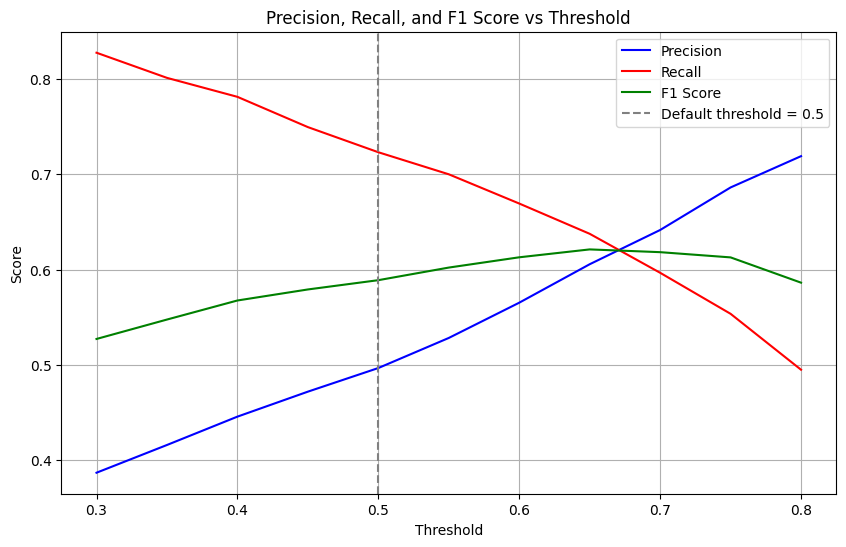

In [113]:
y_proba = best_model_xgb.predict_proba(X_val)[:, 1]
f1_scores, precision_scores, recall_scores = threshold_plot(y_val,y_proba,[0.8,0.75,0.7,0.65,0.6,0.55,0.50, 0.45, 0.40, 0.35, 0.30])

In [114]:
smaller_thresholds = np.linspace(0.6, 0.7,100)
f1_scores, precision_scores, recall_scores = threshold_plot(y_val,y_proba,smaller_thresholds,plot=False)

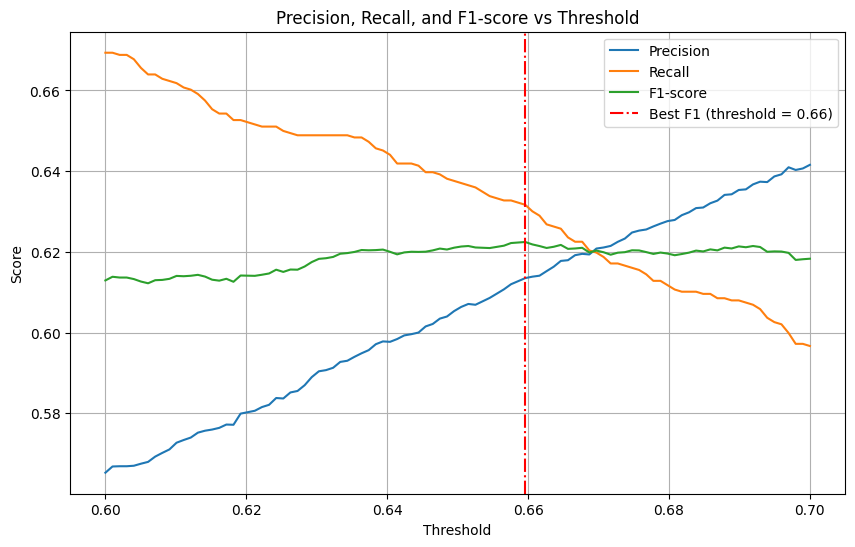

Best F1 = 0.6224 at threshold = 0.6596


In [115]:
max_f1_score_index = np.argmax(f1_scores)
best_f1_score = f1_scores[max_f1_score_index]
best_threshold = smaller_thresholds[max_f1_score_index]

plt.figure(figsize=(10, 6))

plt.plot(smaller_thresholds, precision_scores, label="Precision")
plt.plot(smaller_thresholds, recall_scores, label="Recall")
plt.plot(smaller_thresholds, f1_scores, label="F1-score")

plt.axvline(best_threshold, color="red", linestyle="-.", 
            label=f"Best F1 (threshold = {best_threshold:.2f})")

plt.title("Precision, Recall, and F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best F1 = {best_f1_score:.4f} at threshold = {best_threshold:.4f}")

---
## 6. Results 🛬

### 6.1 Results Interpretation ✏️

Now that we have selected the best-performing machine learning model, tuned its hyperparameters, and identified the optimal threshold for maximizing the minority-class F1-score, we can move to the final evaluation step. Up to this point, all model fitting and threshold optimization were performed using the training and validation sets only. To ensure that our final performance estimate is completely unbiased and that no data leakage occurred during model development, we now evaluate the model on the test set, which has remained unseen throughout the entire process.

As intended throughout the report, the final test metrics (precision, recall, and F1-score) are consistent with the threshold optimization performed earlier. Even though the threshold was chosen to maximize the F1-score, recall remains higher than precision, which reflects the modeling objective: prioritizing the correct identification of positive cases (income >50K), even at the cost of increasing false positives (predicting low-income individuals as high-income).

In [116]:
y_proba = best_model_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba > best_threshold).astype(int)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     54796
           1       0.62      0.63      0.62      3714

    accuracy                           0.95     58510
   macro avg       0.80      0.80      0.80     58510
weighted avg       0.95      0.95      0.95     58510



The ROC-AUC score is 0.9517, which shows the model separates the two classes very well (1 is perfect, 0.5 is random).
The PR-AUC score is 0.6889, which is strong given that the positive class is only ~7%. The baseline PR-AUC would be around 0.07, so a value of 0.69 means the model is much better than chance at detecting high-income individuals.

In [117]:
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)

ROC-AUC: 0.9517379422449186
PR-AUC: 0.6889088926449246


Finally, one final key aspect to englobe a model success or not is the confusion Matrix. It shows that the model performs well on both classes. The top-left value (53,360) is high, which is expected because the negative class is the majority. More importantly, the bottom-right value (2,338) is the second-largest cell, which means the model correctly identifies a good number of high-income individuals. The bottom-left value (1,376) represents the false negatives, and although this number is not small, it is reasonable given the class imbalance and the fact that we intentionally increased recall. Overall, the matrix confirms that the model captures many of the true high-income cases while keeping errors at an acceptable level.

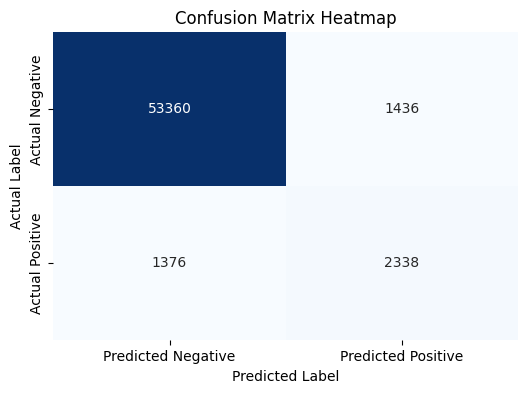

In [118]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

___
### 6.2 Features Importance 📊

A crucial model performance evaluation lies in understanding which features impacts the most wheter a person is or not above the 50k threhsold per annum. The features are the following:

- **Tax_Filler_Status** (Class 0 -> Non Filler) : The strongest feature which is fairly self-explanatory seems totallu logic as in most case where a person does not file tax tend have lower or unstable income, truly seperating both classes

- **Detail_Summary_HouseHold** (Class 0 -> Child under 18) : Once again a strong feature that goes towards classifiyiong easily if a person is within class 0 is if he is a child (to some exceptions of course) 

- **Capital_Total** (Class 1) : The numerical column we created during the feature engineering part did come out to be very helpful, as it helped the model idenitfing person who have more than 50k per year (getting a better importance score than `capital_losses` or `capital_gains`), which highlights the importance of feature engineering.

- **Sex** (both Classes): This variable contributes meaningfully to the prediction. This aligns with the wage differences observed in the EDA and with real-world income patterns.

Overall, the model relies on a combination of demographics (sex, age, marital status), economic indicators (capital gains/losses), employment characteristics (occupation, weeks worked), and household information. These features align well with the factors that logically distinguish higher-income individuals.

In [119]:
# this cell was done with the help of ChatGPT
xgb_final = best_model_xgb.named_steps["model"]
importances = xgb_final.feature_importances_

preprocess = best_model_xgb.named_steps["preprocess"]
feature_names = preprocess.get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

importance_df = importance_df.sort_values("importance", ascending=False)

importance_df.head(20)

,feature,importance
44,low_cat__tax_filer_stat_Nonfiler,0.136951
48,low_cat__detailed_household_summary_in_househo...,0.097046
66,med_cat__detailed_occupation_recode,0.049024
31,low_cat__sex_Male,0.043443
30,low_cat__sex_Female,0.035564
4,num_log__capital_total,0.035501
10,num__weeks_worked_in_year,0.034242
67,med_cat__education,0.026225
8,num__capital_losses,0.019742
23,low_cat__marital_stat_single,0.019227


In [120]:
# in depth feature desciption
importance_df['feature'].head(20).tolist()

['low_cat__tax_filer_stat_Nonfiler',
 'low_cat__detailed_household_summary_in_household_Child under 18 never married',
 'med_cat__detailed_occupation_recode',
 'low_cat__sex_Male',
 'low_cat__sex_Female',
 'num_log__capital_total',
 'num__weeks_worked_in_year',
 'med_cat__education',
 'num__capital_losses',
 'low_cat__marital_stat_single',
 'num_log__capital_losses',
 'num_log__capital_gains',
 'num__capital_gains',
 'low_cat__class_of_worker_not_in_universe',
 'low_cat__detailed_household_summary_in_household_Householder',
 'num__age',
 'low_cat__own_business_or_self_employed_1',
 'low_cat__detailed_household_summary_in_household_Child 18 or older',
 'low_cat__class_of_worker_self_employed',
 'num__dividends_from_stocks']